In [1]:
#importing libraries
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torchvision.utils import make_grid


In [2]:
# downloading MNIST dataset
dataset = MNIST(root='data/', download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:02<00:00, 4923379.11it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6603559.41it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1904094.31it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 26869575.13it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
len(dataset)

60000

Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

Label: 5


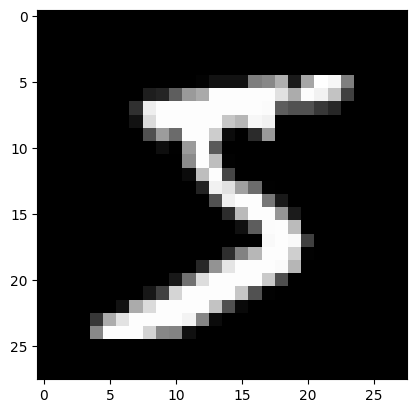

In [4]:
image, label = dataset[0]
# error : Invalid shape (1, 28, 28) for image data therfore, do as below
permuted_img = image.permute(1,2,0)
plt.imshow(permuted_img, cmap='gray')
print('Label:', label)

In [5]:
# training validation split
val_size = 10_000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size = 128

num_workers , which denotes the number of processes that generate batches in parallel. A high enough number of workers assures that CPU computations are efficiently managed, i.e. that the bottleneck is indeed the neural network's forward and backward operations on the GPU (and not data generation).

The pin memory is set to True to the DataLoader which will automatically put the fetched data Tensors in pinned memory, enabling faster data transfer to CUDA-enabled GPU's. For every epoch the data is transferred from CPU to GPU, with augmentations done in the CPU, and trainings done in the GPU.

In [7]:
train_loader = DataLoader(train_ds, batch_size,shuffle=True,num_workers=4)
val_loader = DataLoader(val_ds,2*batch_size,num_workers=4)

Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

In [8]:
# explanation of below fxn
for i,l in train_loader:
    print('image shape:' , i.shape) #([128,1,28,28])
    print('grid shape:', make_grid(i,nrow=16).shape) # ([3,242,482])
    # now according to imshow color channel should be at last therefore
    print("after permutation grid shape: ",make_grid(i,nrow=16).permute(1,2,0).shape)
    break

image shape: torch.Size([128, 1, 28, 28])
grid shape: torch.Size([3, 242, 482])
after permutation grid shape:  torch.Size([242, 482, 3])


image shape: torch.Size([128, 1, 28, 28])


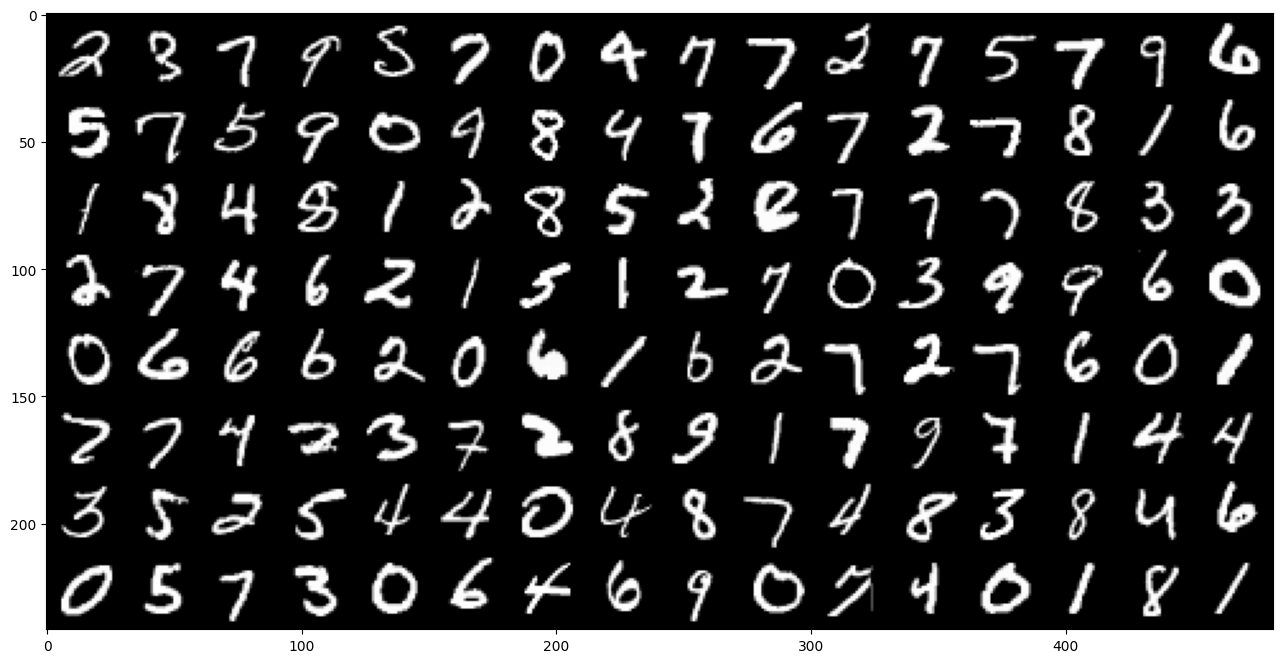

In [9]:
for images,labels in train_loader:
    print('image shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a _hidden layer_ and an _output layer_. Additionally, we'll use an _activation function_ between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [10]:
for images, labels in train_loader:
    print('images shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('input shape:', inputs.shape)
    break

images shape: torch.Size([128, 1, 28, 28])
input shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our _hidden_ layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the _learning capacity_ of the model.

In [11]:
input_size = inputs.shape[-1] # [128,784]
hidden_size  = 32

In [12]:
layer1 = nn.Linear(input_size, hidden_size, bias=True)

In [13]:
inputs.shape

torch.Size([128, 784])

In [14]:
layer1_outputs = layer1(inputs)

In [15]:
layer1_outputs.shape

torch.Size([128, 32])

manually doing the calculation which is performed by the nn.Linear class in forward fxn then checking it

In [16]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [17]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [18]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6138660907745361
min(relu_outputs): 0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [19]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size,bias=True)

In [20]:
layer2_outputs = layer2(relu_outputs)
layer2_outputs.shape

torch.Size([128, 10])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [21]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.3139, grad_fn=<NllLossBackward0>)

Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.

In [22]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [23]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A _deep neural network_ is simply a neural network with one or more hidden layers. In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can _learn_ rich and complex non-linear relationships between inputs and targets. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

In [24]:
# Same as layer2(layer1(inputs))  ->>>>> without activation fxn
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [25]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [26]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [27]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [28]:
class MnistModel(nn.Module):

    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # flatten the tensor
        xb = xb.view(xb.size(0),-1)
        # generate output of hidden layer
        out = self.linear1(xb)
        # activate out
        out = F.relu(out,inplace=True)
        # generate final out
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        '''returns the loss of the batch'''
        images, labels = batch
        # calculate predictions
        out = self(images)
        # calculate loss
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        val_loss = F.cross_entropy(out, labels)
        val_acc = accuracy(out,labels)
        return {'val_loss':val_loss, 'val_acc':val_acc}
    
    def validation_epoch_end(self, outputs): #outputs is a set of dicts where one dict represents one batch of fxn validation_step
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc']  for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item() , 'val_acc' : epoch_acc.item()}
    
    def epoch_end(self,epoch,result): #result is the dict returned by validation_epoch_end fxn
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [29]:
def accuracy(out,labels):
    _, preds = torch.max(out,dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
# declaring size of the layers
input_size = 784
hidden_size = 32
out_size = 10

In [31]:
model = MnistModel(input_size,hidden_size=hidden_size, out_size=out_size)

In [32]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [33]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.316582202911377
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0488,  0.1878,  0.0802, -0.1139,  0.1157, -0.2296,  0.0376,  0.1507,
         -0.0937,  0.1823],
        [ 0.0912, -0.0063,  0.0666, -0.0774,  0.0801, -0.1865,  0.2493,  0.0910,
         -0.1552,  0.2185]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [34]:

torch.cuda.is_available()

False

We can check if a GPU is available for M1 chips and the required mps drivers are installed using `torch.backends.mps.is_available()`.

In [35]:
torch.backends.mps.is_available()

True

In [36]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't. 

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

In [38]:
device = get_default_device()
device

device(type='mps')

In [39]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [40]:
for images, labels in train_loader:
    print(images.shape)
    print(images.device)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu
mps:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [41]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using `DeviceDataLoader`.

In [42]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors moved to the GPU have a `device` property which includes that word `mps`. Let's verify this by looking at a batch of data from `valid_dl`.

In [43]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: mps:0
yb: tensor([4, 7, 7, 4, 4, 5, 6, 5, 8, 7, 3, 9, 0, 8, 6, 0, 3, 7, 8, 1, 5, 5, 3, 9,
        7, 0, 1, 0, 9, 8, 8, 7, 0, 4, 6, 2, 0, 1, 8, 6, 7, 6, 1, 1, 0, 9, 1, 3,
        2, 5, 9, 7, 8, 4, 1, 5, 5, 3, 3, 8, 0, 8, 0, 3, 9, 8, 0, 6, 1, 6, 6, 2,
        4, 4, 1, 7, 6, 1, 1, 3, 4, 3, 0, 9, 6, 1, 4, 2, 0, 7, 8, 6, 0, 4, 1, 1,
        3, 8, 0, 2, 3, 4, 6, 4, 3, 7, 0, 7, 3, 1, 5, 1, 3, 1, 4, 0, 7, 8, 6, 0,
        9, 6, 6, 5, 8, 1, 4, 8, 3, 7, 3, 7, 2, 5, 6, 4, 0, 1, 0, 1, 1, 7, 5, 8,
        8, 2, 1, 4, 1, 7, 3, 0, 3, 7, 9, 9, 6, 1, 1, 4, 7, 9, 7, 9, 4, 8, 3, 4,
        8, 3, 0, 9, 7, 5, 7, 3, 4, 7, 1, 2, 2, 2, 6, 1, 5, 3, 9, 8, 4, 8, 3, 1,
        8, 9, 6, 5, 9, 8, 5, 6, 8, 6, 2, 9, 1, 2, 8, 7, 3, 7, 4, 4, 4, 8, 0, 0,
        4, 4, 6, 9, 3, 8, 5, 2, 0, 6, 7, 7, 4, 1, 9, 1, 2, 1, 8, 1, 2, 3, 8, 3,
        0, 7, 7, 6, 7, 7, 0, 4, 0, 3, 6, 6, 0, 4, 3, 2], device='mps:0')


## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. 

In [44]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [45]:
def fit(epochs, lr,model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #validatio phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history     

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [46]:
model = MnistModel(input_size, hidden_size, out_size)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [47]:
device

device(type='mps')

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [48]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3096747398376465, 'val_acc': 0.04062499850988388}]

The initial accuracy is around 4%, as one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).



In [49]:
history += fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4331, val_acc: 0.8813
Epoch [1], val_loss: 0.3455, val_acc: 0.9027
Epoch [2], val_loss: 0.3179, val_acc: 0.9076
Epoch [3], val_loss: 0.2932, val_acc: 0.9187
Epoch [4], val_loss: 0.2767, val_acc: 0.9213
Epoch [5], val_loss: 0.2593, val_acc: 0.9276
Epoch [6], val_loss: 0.2490, val_acc: 0.9306
Epoch [7], val_loss: 0.2368, val_acc: 0.9338
Epoch [8], val_loss: 0.2280, val_acc: 0.9366
Epoch [9], val_loss: 0.2197, val_acc: 0.9381


lets' see if we can imporve accuracy further

In [50]:
history += fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2142, val_acc: 0.9386
Epoch [1], val_loss: 0.2088, val_acc: 0.9400
Epoch [2], val_loss: 0.2030, val_acc: 0.9414
Epoch [3], val_loss: 0.1961, val_acc: 0.9437
Epoch [4], val_loss: 0.1906, val_acc: 0.9452
Epoch [5], val_loss: 0.1887, val_acc: 0.9448
Epoch [6], val_loss: 0.1856, val_acc: 0.9458
Epoch [7], val_loss: 0.1809, val_acc: 0.9484
Epoch [8], val_loss: 0.1761, val_acc: 0.9486
Epoch [9], val_loss: 0.1774, val_acc: 0.9479


In [51]:
history += fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1721, val_acc: 0.9495
Epoch [1], val_loss: 0.1681, val_acc: 0.9510
Epoch [2], val_loss: 0.1667, val_acc: 0.9517
Epoch [3], val_loss: 0.1648, val_acc: 0.9523
Epoch [4], val_loss: 0.1611, val_acc: 0.9526
Epoch [5], val_loss: 0.1576, val_acc: 0.9534
Epoch [6], val_loss: 0.1576, val_acc: 0.9524
Epoch [7], val_loss: 0.1576, val_acc: 0.9528
Epoch [8], val_loss: 0.1524, val_acc: 0.9558
Epoch [9], val_loss: 0.1521, val_acc: 0.9557


In [52]:
history += fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1502, val_acc: 0.9568
Epoch [1], val_loss: 0.1520, val_acc: 0.9536
Epoch [2], val_loss: 0.1476, val_acc: 0.9555
Epoch [3], val_loss: 0.1472, val_acc: 0.9564
Epoch [4], val_loss: 0.1463, val_acc: 0.9567
Epoch [5], val_loss: 0.1420, val_acc: 0.9578
Epoch [6], val_loss: 0.1402, val_acc: 0.9580
Epoch [7], val_loss: 0.1413, val_acc: 0.9565
Epoch [8], val_loss: 0.1382, val_acc: 0.9591
Epoch [9], val_loss: 0.1379, val_acc: 0.9582


We can now plot the losses & accuracies to study how the model improves over time.

Text(0.5, 1.0, 'Loss vs. No. of epochs')

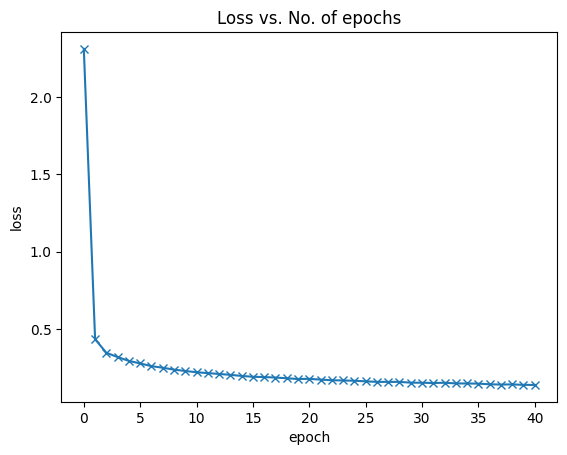

In [53]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

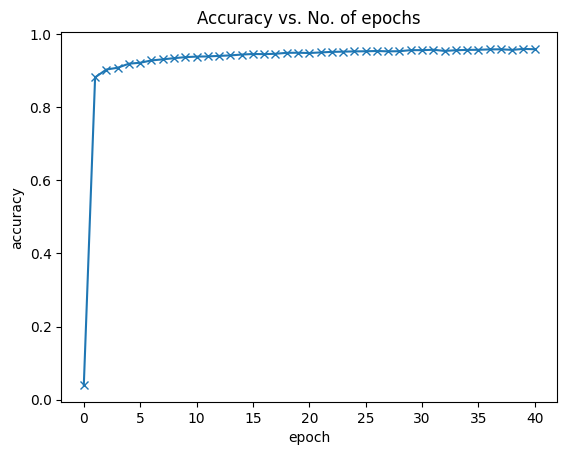

In [54]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [55]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [56]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Let's try it out with a few images.

Label: 2 , Predicted: 2


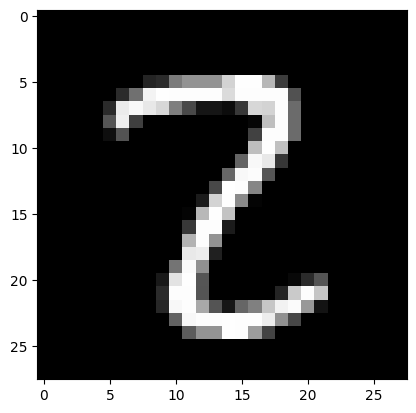

In [57]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 8 , Predicted: 8


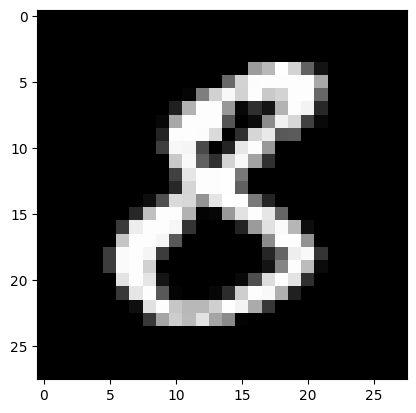

In [58]:
img, label = test_dataset[1234]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 4 , Predicted: 4


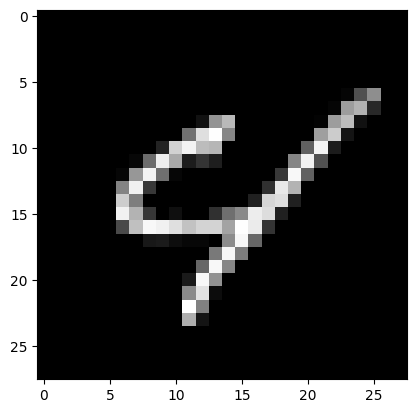

In [59]:
img, label = test_dataset[420]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [60]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.11597692221403122, 'val_acc': 0.965039074420929}

our model has achieved an accuracy of 96.5% over MNIST test data set